In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from config import db_password
# Initial imports.
import pandas as pd
from path import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
df=pd.read_csv('../../all_records.csv')

In [3]:
df=df.drop(columns=['Unnamed: 0','Name_outcome','MonthYear_intake','MonthYear_outcome',
                    'gender_intake','gender_outcome','fixed_intake','fixed_outcome','Days_length','Outcome_Subtype',
                   'retriever','shepherd','beagle','terrier','boxer','poodle','rottweiler','dachshund','chihuahua',
                   'pit bull','Age','Age_upon_Outcome','Found_Location'])
df.head()

,Animal ID,Name_intake,DateTime_intake,Intake_Type,IntakeCondition,Animal_Type_intake,Sex,Breed_intake,Color_intake,DateTime_outcome,Outcome_Type,Sex_upon_Outcome,fixed_changed,Age_Bucket,DateTime_length
0,A730601,NaN,2016-07-07 12:11:00,Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Blue Tabby,2016-07-08 09:00:00,Transfer,Neutered Male,1,7-12 months,0 days 20:49:00.000000000
1,A683644,*Zoey,2014-07-13 11:02:00,Owner Surrender,Nursing,Dog,Intact Female,Border Collie Mix,Brown/White,2014-11-06 10:06:00,Adoption,Spayed Female,1,1-6 weeks,115 days 23:04:00.000000000
2,A676515,Rico,2014-04-11 08:45:00,Stray,Normal,Dog,Intact Male,Pit Bull Mix,White/Brown,2014-04-14 18:38:00,Return to Owner,Neutered Male,1,1-6 months,3 days 09:53:00.000000000
3,A742953,NaN,2017-01-31 13:30:00,Stray,Normal,Dog,Intact Male,Saluki,Sable/Cream,2017-02-04 14:17:00,Transfer,Intact Male,0,1-3 years,4 days 00:47:00.000000000
4,A679549,*Gilbert,2014-05-22 15:43:00,Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black/White,2014-06-16 13:54:00,Transfer,Neutered Male,1,1-6 months,24 days 22:11:00.000000000


# Preprocessing Data

In [4]:
# Change Name_Intake to Yes or No
df.Name_intake = df.Name_intake.apply(lambda x: 'No' if pd.isnull(x) else 'Yes')
df.Name_intake.value_counts()

Yes    57493
No     19484
Name: Name_intake, dtype: int64

In [5]:
df.isnull().sum()

Animal ID             0
Name_intake           0
DateTime_intake       0
Intake_Type           0
IntakeCondition       0
Animal_Type_intake    0
Sex                   1
Breed_intake          0
Color_intake          0
DateTime_outcome      0
Outcome_Type          7
Sex_upon_Outcome      4
fixed_changed         0
Age_Bucket            0
DateTime_length       0
dtype: int64

In [6]:
df=df.dropna()

In [7]:
# Check for duplicates rows
count=0
for i in df['Animal ID'].duplicated():
    if i is True:
        count+=1
count

19762

In [8]:
df=df.drop_duplicates(subset='Animal ID')

In [9]:
# Combine Died & Disposal Outcomes
df.loc[df.Outcome_Type == 'Disposal', 'Outcome_Type'] = 'Died'
df.Outcome_Type.value_counts()

Adoption           22988
Transfer           18460
Return to Owner     9806
Euthanasia          5100
Died                 787
Missing               37
Rto-Adopt             15
Relocate              13
Name: Outcome_Type, dtype: int64

In [10]:
# Combine Transfer & Relocate Outcomes
df.loc[df.Outcome_Type == 'Relocate', 'Outcome_Type'] = 'Transfer'
df.Outcome_Type.value_counts()

Adoption           22988
Transfer           18473
Return to Owner     9806
Euthanasia          5100
Died                 787
Missing               37
Rto-Adopt             15
Name: Outcome_Type, dtype: int64

In [11]:
#### Combine Rto-Adopt & Return to Owner
df.loc[df.Outcome_Type == 'Rto-Adopt', 'Outcome_Type'] = 'Return to Owner'
df.Outcome_Type.value_counts()

Adoption           22988
Transfer           18473
Return to Owner     9821
Euthanasia          5100
Died                 787
Missing               37
Name: Outcome_Type, dtype: int64

In [12]:
df.loc[df.Outcome_Type == 'Missing', 'Outcome_Type'] = None
df.Outcome_Type.value_counts()

Adoption           22988
Transfer           18473
Return to Owner     9821
Euthanasia          5100
Died                 787
Name: Outcome_Type, dtype: int64

In [13]:
df.loc[df.Outcome_Type == 'Euthanasia', 'Outcome_Type'] = 'Died'
df.Outcome_Type.value_counts()

Adoption           22988
Transfer           18473
Return to Owner     9821
Died                5887
Name: Outcome_Type, dtype: int64

In [14]:
df.isnull().sum()

Animal ID              0
Name_intake            0
DateTime_intake        0
Intake_Type            0
IntakeCondition        0
Animal_Type_intake     0
Sex                    0
Breed_intake           0
Color_intake           0
DateTime_outcome       0
Outcome_Type          37
Sex_upon_Outcome       0
fixed_changed          0
Age_Bucket             0
DateTime_length        0
dtype: int64

In [15]:
df.dropna()

,Animal ID,Name_intake,DateTime_intake,Intake_Type,IntakeCondition,Animal_Type_intake,Sex,Breed_intake,Color_intake,DateTime_outcome,Outcome_Type,Sex_upon_Outcome,fixed_changed,Age_Bucket,DateTime_length
0,A730601,No,2016-07-07 12:11:00,Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Blue Tabby,2016-07-08 09:00:00,Transfer,Neutered Male,1,7-12 months,0 days 20:49:00.000000000
1,A683644,Yes,2014-07-13 11:02:00,Owner Surrender,Nursing,Dog,Intact Female,Border Collie Mix,Brown/White,2014-11-06 10:06:00,Adoption,Spayed Female,1,1-6 weeks,115 days 23:04:00.000000000
2,A676515,Yes,2014-04-11 08:45:00,Stray,Normal,Dog,Intact Male,Pit Bull Mix,White/Brown,2014-04-14 18:38:00,Return to Owner,Neutered Male,1,1-6 months,3 days 09:53:00.000000000
3,A742953,No,2017-01-31 13:30:00,Stray,Normal,Dog,Intact Male,Saluki,Sable/Cream,2017-02-04 14:17:00,Transfer,Intact Male,0,1-3 years,4 days 00:47:00.000000000
4,A679549,Yes,2014-05-22 15:43:00,Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black/White,2014-06-16 13:54:00,Transfer,Neutered Male,1,1-6 months,24 days 22:11:00.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76971,A746679,Yes,2017-04-07 09:44:00,Stray,Normal,Cat,Spayed Female,Domestic Shorthair Mix,Tortie,2017-04-08 11:14:00,Return to Owner,Spayed Female,0,1-3 years,1 days 01:30:00.000000000
76972,A746725,No,2017-04-08 11:28:00,Stray,Normal,Cat,Unknown,Domestic Shorthair Mix,Blue/White,2017-04-08 11:42:00,Died,Unknown,0,1-6 weeks,0 days 00:14:00.000000000
76973,A746689,Yes,2017-04-07 12:36:00,Stray,Normal,Dog,Spayed Female,Chihuahua Shorthair Mix,White/Tan,2017-04-08 11:32:00,Return to Owner,Spayed Female,0,1-3 years,0 days 22:56:00.000000000
76974,A746466,Yes,2017-04-03 15:02:00,Stray,Normal,Dog,Intact Male,Basset Hound Mix,White/Brown,2017-04-08 12:21:00,Adoption,Neutered Male,1,1-6 months,4 days 21:19:00.000000000


In [16]:
# Update DateTime_intake to datatime datatype
df.DateTime_intake = pd.to_datetime(df.DateTime_intake, format='%Y-%m-%d')

In [17]:
# Update DateTime_outcome to datatime datatype
df.DateTime_outcome = pd.to_datetime(df.DateTime_outcome, format='%Y-%m-%d')

In [18]:
# Create a new column and calculate the length of stay
df['datetime_length']=df['DateTime_outcome']-df['DateTime_intake']

In [19]:
# Create a temporary 'int' column and convert datetime to int
df['int'] = df['datetime_length'].astype(np.int64)

In [20]:
# replace negative values to nan
df.loc[df.int < 0, 'int'] = None

In [21]:
# Check for null values
df.isnull().sum()

Animal ID                0
Name_intake              0
DateTime_intake          0
Intake_Type              0
IntakeCondition          0
Animal_Type_intake       0
Sex                      0
Breed_intake             0
Color_intake             0
DateTime_outcome         0
Outcome_Type            37
Sex_upon_Outcome         0
fixed_changed            0
Age_Bucket               0
DateTime_length          0
datetime_length          0
int                   1400
dtype: int64

In [22]:
# drop null values
df=df.dropna()

In [23]:
# drop temporary 'int' column and original DateTime_length column
df=df.drop(columns=['DateTime_length','datetime_length'])

# Rename calculated length of stay column
df.rename(columns = {'int':'DateTime_length'}, inplace = True)

In [24]:
# Combine Aged and Feral with Other for IntakeCondition
df.loc[(df.IntakeCondition == 'Aged') | (df.IntakeCondition == 'Feral'), 'IntakeCondition'] = 'Other'

In [25]:
# Combine Injured and Sick for Intake Condition
df.loc[(df.IntakeCondition == 'Injured') | (df.IntakeCondition == 'Sick'), 'IntakeCondition'] = 'Medical'

In [26]:
# Combine Pregnant and Nursing for  IntakeCondition
df.loc[(df.IntakeCondition == 'Nursing') | (df.IntakeCondition == 'Pregnant'), 'IntakeCondition' ] = 'Maternity'
df.IntakeCondition.value_counts()

Normal       48301
Medical       5474
Maternity     1562
Other          434
Name: IntakeCondition, dtype: int64

In [27]:
# Combine Bird and Livestock with Other for Animal_Type_intake
df.loc[(df.Animal_Type_intake == 'Bird') | (df.Animal_Type_intake == 'Livestock'), 'Animal_Type_intake'] = 'Other'
df.Animal_Type_intake.value_counts()

Dog      30030
Cat      22035
Other     3706
Name: Animal_Type_intake, dtype: int64

In [28]:
df.rename(columns={'Sex': 'Sex_Intake'}, inplace=True)

In [29]:
# Find Mix breeds
new_breed=[]
for i in df['Breed_intake']:
    if 'Mix' in i:
        i='Mix'
    elif "/" in i:
        i="Mix"
    elif 'Chihuahua' in i:
        i = 'Chihuahua'
    elif 'Retriever' in i or i=='Chesa Bay Retr':
        i = 'Retriever Breeds'
    elif 'Bull' in i or 'Staffordshire' in i or i=='Chinese Sharpei' or i=='Dogo Argentino' or i=='Boxer':
        i = 'Bully Breeds'
    elif 'Terrier' in i:
        i= 'Terrier Breeds'
    elif i=='Bat' or i=='Raccoon' or i=='Opossum' or i=='Duck' or i=='Fox' or i=='Grackle' or i=='Hawk' or i=='Coyote' or i=='Pigeon' or i=='Dove' or i=='Armadillo' or i=='Owl' or i=='Skunk' or i=='Squirrel' or i=='Mockingbird' or i=='Heron' or i=='Sparrow':
        i = 'Wildlife'
    elif i=='German Shepherd' or i=='Belgian Malinois':
        i = 'German Shepherd'
    elif 'Pointer' in i or 'Span' in i or i=='Vizsla' or i=='Brittany' or i=='Shiba Inu' or i=='Dalmatian' or i=='Standard Poodle' or i=='Carolina Dog' or i=='Weimaraner':
        i = 'Sporting Breeds'
    elif 'hound' in i or 'Hound' in i or i=='Beagle' or i=='Saluki' or 'Coon' in i or i=='Catahoula' or i=='Black Mouth Cur' or i=='Harrier' or i=='Blue Lacy' or i=='Treeing Tennesse Brindle' or i=='Whippet':
        i = 'Hound Breeds'
    elif 'Husky' in i or 'Malamute' in i or 'Eskimo' in i or i=='Finnish Spitz' or i=='Samoyed' or i=='Keeshond' or i=='Jindo':
        i = 'Husky Breeds'
    elif i=='Shih Tzu' or i=='Miniature Poodle' or i=='Miniature Schnauzer' or i=='Maltese' or i=='Pomeranian' or i=='Lhasa Apso' or i=='Toy Poodle' or i=='Pekingese' or i=='Bichon Frise' or i=='Cavalier Span' or i=='West Highland' or i=='Papillon' or i=='Havanese' or i=='Japanese Chin' or i=='Dandie Dinmont' or i=='Bruss Griffon' or i=='Coton De Tulear' or 'Dachshund' in i or i=='French Bulldog' or i=='Pug' or i=='Miniature Pinscher' or i=='Pbgv':
        i = 'Toy Breeds'
    elif 'Australian' in i or 'Collie' in i or 'Heeler' in i or 'Sheepdog' in i or i=='English Shepherd' or i=='Dutch Shepherd' or 'Corgi' in i or i=='Beauceron' or i=='Hovawart':
        i = 'Herding Breeds'
    elif i=='Chinese Sharpei' or i=='Chow Chow' or i=='Standard Schnauzer' or i=='Basenji' or i=='Rottweiler' or i=='Doberman Pinsch':
        i = 'Working Breeds'
    elif i=='Great Pyrenees' or i=='Great Dane' or i=='Anatol Shepherd' or i=='Cane Corso' or i=='Rhod Ridgeback' or i=='Akita' or i=='Mastiff' or i=='Presa Canario' or 'Bernese' in i or i=='Burmese' or 'Bernard' in i or i=='Leonberger' or i=='Greater Swiss Mountain Dog' or i=='Boerboel'or i=='Landseer':
        i = 'X Large Breeds'
    elif i=='Domestic Shorthair':
        i = 'Domestic Shorthair'
    elif i=='Domestic Medium Hair':
        i = 'Domestic Medium Hair'
    elif i=='Persian' or i=='Siamese' or i=='Domestic Longhair' or i=='Persian' or i=='Himalayan' or i=='Russian Blue' or i=='Bengal' or i=='Devon Rex' or i=='Sphynx' or i=='British Shorthair' or i=='Manx':
        i = 'Other Cat'
    else:
        i='Other'
    new_breed.append(i)
new_breed

['Mix',
 'Mix',
 'Mix',
 'Hound Breeds',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Toy Breeds',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Wildlife',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Hound Breeds',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 'Mix',
 '

In [30]:
df["new_breed"]=new_breed

In [31]:
breed_counts=df['new_breed'].value_counts()
breed_counts

Mix                     51899
Wildlife                 1060
Toy Breeds                446
Bully Breeds              318
Domestic Shorthair        299
Other                     186
Terrier Breeds            173
Retriever Breeds          172
Herding Breeds            167
Chihuahua                 166
Hound Breeds              153
German Shepherd           138
Domestic Medium Hair      109
Working Breeds            107
Other Cat                 104
X Large Breeds             99
Sporting Breeds            96
Husky Breeds               79
Name: new_breed, dtype: int64

In [32]:
df.loc[df.new_breed == 'Retriever Breeds', 'new_breed'] = 'Sporting Breeds'
df.loc[df.new_breed == 'Chihuahua', 'new_breed'] = 'Toy Breeds'
df.loc[df.new_breed == 'German Shepherd', 'new_breed'] = 'Working Breeds'
df.loc[df.new_breed == 'Husky Breeds', 'new_breed'] = 'Sporting Breeds'
df['new_breed'].value_counts()

Mix                     51899
Wildlife                 1060
Toy Breeds                612
Sporting Breeds           347
Bully Breeds              318
Domestic Shorthair        299
Working Breeds            245
Other                     186
Terrier Breeds            173
Herding Breeds            167
Hound Breeds              153
Domestic Medium Hair      109
Other Cat                 104
X Large Breeds             99
Name: new_breed, dtype: int64

In [33]:
replace_breed=breed_counts.loc[breed_counts<150].index.tolist()
for i in replace_breed:
    df.new_breed = df.new_breed.replace(i,"Other")

df.new_breed.value_counts()

Mix                   51899
Other                  1090
Wildlife               1060
Toy Breeds              612
Bully Breeds            318
Domestic Shorthair      299
Terrier Breeds          173
Herding Breeds          167
Hound Breeds            153
Name: new_breed, dtype: int64

In [34]:
# drop and rename
df=df.drop(columns=['Breed_intake'])
df=df.rename(columns={"new_breed": "Breed_Type"})
df.head()

,Animal ID,Name_intake,DateTime_intake,Intake_Type,IntakeCondition,Animal_Type_intake,Sex_Intake,Color_intake,DateTime_outcome,Outcome_Type,Sex_upon_Outcome,fixed_changed,Age_Bucket,DateTime_length,Breed_Type
0,A730601,No,2016-07-07 12:11:00,Stray,Normal,Cat,Intact Male,Blue Tabby,2016-07-08 09:00:00,Transfer,Neutered Male,1,7-12 months,7.494000e+13,Mix
1,A683644,Yes,2014-07-13 11:02:00,Owner Surrender,Maternity,Dog,Intact Female,Brown/White,2014-11-06 10:06:00,Adoption,Spayed Female,1,1-6 weeks,1.001904e+16,Mix
2,A676515,Yes,2014-04-11 08:45:00,Stray,Normal,Dog,Intact Male,White/Brown,2014-04-14 18:38:00,Return to Owner,Neutered Male,1,1-6 months,2.947800e+14,Mix
3,A742953,No,2017-01-31 13:30:00,Stray,Normal,Dog,Intact Male,Sable/Cream,2017-02-04 14:17:00,Transfer,Intact Male,0,1-3 years,3.484200e+14,Hound Breeds
4,A679549,Yes,2014-05-22 15:43:00,Stray,Normal,Cat,Intact Male,Black/White,2014-06-16 13:54:00,Transfer,Neutered Male,1,1-6 months,2.153460e+15,Mix


In [35]:
colorNew=[]
for i in df.Color_intake:
    if "/" in i:
        i="Bicolor"
    elif "Tabby" in i:
        i='Tabby'
    elif "Brindle" in i:
        i="Tabby"
    elif "Merle" in i:
        i="Merle"
    elif "Tiger" in i:
        i="Tiger"
    elif "Tortie" in i:
        i="Tabby"
    elif "Calico" in i:
        i="Tabby"
    elif "Torbie" in i:
        i="Tabby"
    elif i=="Apricot" or i=="Gold" or i=="Yellow" or i=="Fawn":
        i="Orange"
    elif "Blue" in i:
        i="Blue"
    elif "Black" in i or i=="Sable":
        i="Black"
    elif i=="Liver":
        i="Brown"
    elif "Point" in i:
        i='Point'
    elif "Tick" in i:
        i="Point"
    else:
        i=i
    colorNew.append(i)
print(set(colorNew))
print(len(set(colorNew)))

{'Chocolate', 'Tabby', 'Black', 'Agouti', 'Red', 'White', 'Tan', 'Blue', 'Cream', 'Silver', 'Buff', 'Bicolor', 'Merle', 'Green', 'Orange', 'Tricolor', 'Point', 'Brown', 'Tiger', 'Gray', 'Pink'}
21


In [36]:
df['Color_intake']=colorNew

In [37]:
color_counts=df['Color_intake'].value_counts()
color_counts

Bicolor      28286
Tabby         9877
Black         5167
Brown         2585
White         1964
Tricolor      1475
Tan           1360
Blue          1090
Point          912
Red            752
Orange         690
Gray           379
Cream          307
Buff           301
Chocolate      281
Merle          245
Pink            29
Silver          28
Green           20
Tiger           14
Agouti           9
Name: Color_intake, dtype: int64

In [38]:
df.loc[df.Color_intake.isin(['Red', 'Orange']), 'Color_intake'] = 'Tan'

In [39]:
replace_color=color_counts.loc[color_counts<500].index.tolist()
for i in replace_color:
    df.Color_intake = df.Color_intake.replace(i,"Other")

df.Color_intake.value_counts()

Bicolor     28286
Tabby        9877
Black        5167
Tan          2802
Brown        2585
White        1964
Other        1613
Tricolor     1475
Blue         1090
Point         912
Name: Color_intake, dtype: int64

In [40]:
intake_df=df[['Animal ID','DateTime_intake','Intake_Type','IntakeCondition',
             'Animal_Type_intake',
              'Name_intake',
             'Sex_Intake',
             'Color_intake',
             'Breed_Type']]

columns_intake=['animal_id','datetime_intake','intake_type','intake_condition','animal_type_intake',
        'name_intake','sex_intake','color_intake','breed_type']

intake_df.columns =columns_intake
intake_df.head()

,animal_id,datetime_intake,intake_type,intake_condition,animal_type_intake,name_intake,sex_intake,color_intake,breed_type
0,A730601,2016-07-07 12:11:00,Stray,Normal,Cat,No,Intact Male,Tabby,Mix
1,A683644,2014-07-13 11:02:00,Owner Surrender,Maternity,Dog,Yes,Intact Female,Bicolor,Mix
2,A676515,2014-04-11 08:45:00,Stray,Normal,Dog,Yes,Intact Male,Bicolor,Mix
3,A742953,2017-01-31 13:30:00,Stray,Normal,Dog,No,Intact Male,Bicolor,Hound Breeds
4,A679549,2014-05-22 15:43:00,Stray,Normal,Cat,Yes,Intact Male,Bicolor,Mix


In [41]:
outcome_df=df[['Animal ID','DateTime_outcome',
              'Outcome_Type',
              'Sex_upon_Outcome','fixed_changed','Age_Bucket','DateTime_length']]

columns_outcome=['animal_id','datetime_outcome','outcome_type',
                 'sex_upon_outcome','fixed_changed','age_bucket','datetime_length']

outcome_df.columns=columns_outcome

outcome_df.head()

,animal_id,datetime_outcome,outcome_type,sex_upon_outcome,fixed_changed,age_bucket,datetime_length
0,A730601,2016-07-08 09:00:00,Transfer,Neutered Male,1,7-12 months,7.494000e+13
1,A683644,2014-11-06 10:06:00,Adoption,Spayed Female,1,1-6 weeks,1.001904e+16
2,A676515,2014-04-14 18:38:00,Return to Owner,Neutered Male,1,1-6 months,2.947800e+14
3,A742953,2017-02-04 14:17:00,Transfer,Intact Male,0,1-3 years,3.484200e+14
4,A679549,2014-06-16 13:54:00,Transfer,Neutered Male,1,1-6 months,2.153460e+15


In [42]:
outcome_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55771 entries, 0 to 76975
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   animal_id         55771 non-null  object        
 1   datetime_outcome  55771 non-null  datetime64[ns]
 2   outcome_type      55771 non-null  object        
 3   sex_upon_outcome  55771 non-null  object        
 4   fixed_changed     55771 non-null  int64         
 5   age_bucket        55771 non-null  object        
 6   datetime_length   55771 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 3.4+ MB


In [43]:
# merge data
all_df = intake_df.merge(outcome_df, on='animal_id', how='left')
all_df.head()

,animal_id,datetime_intake,intake_type,intake_condition,animal_type_intake,name_intake,sex_intake,color_intake,breed_type,datetime_outcome,outcome_type,sex_upon_outcome,fixed_changed,age_bucket,datetime_length
0,A730601,2016-07-07 12:11:00,Stray,Normal,Cat,No,Intact Male,Tabby,Mix,2016-07-08 09:00:00,Transfer,Neutered Male,1,7-12 months,7.494000e+13
1,A683644,2014-07-13 11:02:00,Owner Surrender,Maternity,Dog,Yes,Intact Female,Bicolor,Mix,2014-11-06 10:06:00,Adoption,Spayed Female,1,1-6 weeks,1.001904e+16
2,A676515,2014-04-11 08:45:00,Stray,Normal,Dog,Yes,Intact Male,Bicolor,Mix,2014-04-14 18:38:00,Return to Owner,Neutered Male,1,1-6 months,2.947800e+14
3,A742953,2017-01-31 13:30:00,Stray,Normal,Dog,No,Intact Male,Bicolor,Hound Breeds,2017-02-04 14:17:00,Transfer,Intact Male,0,1-3 years,3.484200e+14
4,A679549,2014-05-22 15:43:00,Stray,Normal,Cat,Yes,Intact Male,Bicolor,Mix,2014-06-16 13:54:00,Transfer,Neutered Male,1,1-6 months,2.153460e+15


In [44]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55771 entries, 0 to 55770
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   animal_id           55771 non-null  object        
 1   datetime_intake     55771 non-null  datetime64[ns]
 2   intake_type         55771 non-null  object        
 3   intake_condition    55771 non-null  object        
 4   animal_type_intake  55771 non-null  object        
 5   name_intake         55771 non-null  object        
 6   sex_intake          55771 non-null  object        
 7   color_intake        55771 non-null  object        
 8   breed_type          55771 non-null  object        
 9   datetime_outcome    55771 non-null  datetime64[ns]
 10  outcome_type        55771 non-null  object        
 11  sex_upon_outcome    55771 non-null  object        
 12  fixed_changed       55771 non-null  int64         
 13  age_bucket          55771 non-null  object    

In [45]:
new_df=all_df.drop(columns=['animal_id','datetime_intake','datetime_outcome',
                    'sex_intake','fixed_changed'])
new_df.head()

,intake_type,intake_condition,animal_type_intake,name_intake,color_intake,breed_type,outcome_type,sex_upon_outcome,age_bucket,datetime_length
0,Stray,Normal,Cat,No,Tabby,Mix,Transfer,Neutered Male,7-12 months,7.494000e+13
1,Owner Surrender,Maternity,Dog,Yes,Bicolor,Mix,Adoption,Spayed Female,1-6 weeks,1.001904e+16
2,Stray,Normal,Dog,Yes,Bicolor,Mix,Return to Owner,Neutered Male,1-6 months,2.947800e+14
3,Stray,Normal,Dog,No,Bicolor,Hound Breeds,Transfer,Intact Male,1-3 years,3.484200e+14
4,Stray,Normal,Cat,Yes,Bicolor,Mix,Transfer,Neutered Male,1-6 months,2.153460e+15


In [46]:
from sklearn.preprocessing import LabelEncoder

In [47]:
# encode text columns with dummy values
df_encoded = pd.get_dummies(new_df, columns=['intake_type', 'intake_condition', 'animal_type_intake', 'name_intake', 
                    'color_intake', 'sex_upon_outcome', 'age_bucket', 'breed_type'])

In [48]:
le = LabelEncoder()
df_encoded['outcome_type'] = le.fit_transform(df_encoded['outcome_type'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Adoption': 0, 'Died': 1, 'Return to Owner': 2, 'Transfer': 3}


In [49]:
df_encoded.head()

,outcome_type,datetime_length,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,intake_condition_Maternity,intake_condition_Medical,intake_condition_Normal,...,age_bucket_Less than 1 week,breed_type_Bully Breeds,breed_type_Domestic Shorthair,breed_type_Herding Breeds,breed_type_Hound Breeds,breed_type_Mix,breed_type_Other,breed_type_Terrier Breeds,breed_type_Toy Breeds,breed_type_Wildlife
0,3,7.494000e+13,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,1.001904e+16,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,2.947800e+14,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,3,3.484200e+14,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,3,2.153460e+15,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [50]:
# Define the features set.
X = df_encoded.copy()
X=X.drop('outcome_type',axis=1)
X.head()

,datetime_length,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,intake_condition_Maternity,intake_condition_Medical,intake_condition_Normal,intake_condition_Other,...,age_bucket_Less than 1 week,breed_type_Bully Breeds,breed_type_Domestic Shorthair,breed_type_Herding Breeds,breed_type_Hound Breeds,breed_type_Mix,breed_type_Other,breed_type_Terrier Breeds,breed_type_Toy Breeds,breed_type_Wildlife
0,7.494000e+13,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1.001904e+16,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2.947800e+14,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,3.484200e+14,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,2.153460e+15,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [51]:
# Define the target set.
y = df_encoded["outcome_type"].ravel()
y[:5]

array([3, 0, 2, 3, 3])

In [52]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [53]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Resampling

In [54]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

# Random Forest

In [55]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [56]:
# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

In [57]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [58]:
results = pd.DataFrame({
   "Prediction": predictions,
   "Actual": y_test
}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,3,0
1,2,2
2,3,3
3,0,0
4,0,3


In [59]:
# print confusion matrix
cm = confusion_matrix(predictions, y_test)
cm_df = pd.DataFrame(cm,
                     index = ['Adoption', 'Died', 'Return to Owner','Transfer'], 
                     columns = ['Adoption', 'Died', 'Return to Owner','Transfer'])
cm_df

,Adoption,Died,Return to Owner,Transfer
Adoption,4512,85,265,1051
Died,102,1090,52,290
Return to Owner,353,68,1926,253
Transfer,537,190,153,3016


In [60]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [61]:
print(f"Accuracy Score : {acc_score}")
# print classification report
print(classification_report(predictions, y_test, target_names=['Adoption', 'Died', 'Return to Owner','Transfer']))

Accuracy Score : 0.7562217600229506
                 precision    recall  f1-score   support

       Adoption       0.82      0.76      0.79      5913
           Died       0.76      0.71      0.73      1534
Return to Owner       0.80      0.74      0.77      2600
       Transfer       0.65      0.77      0.71      3896

       accuracy                           0.76     13943
      macro avg       0.76      0.75      0.75     13943
   weighted avg       0.76      0.76      0.76     13943



<AxesSubplot:title={'center':'Feature Importance'}>

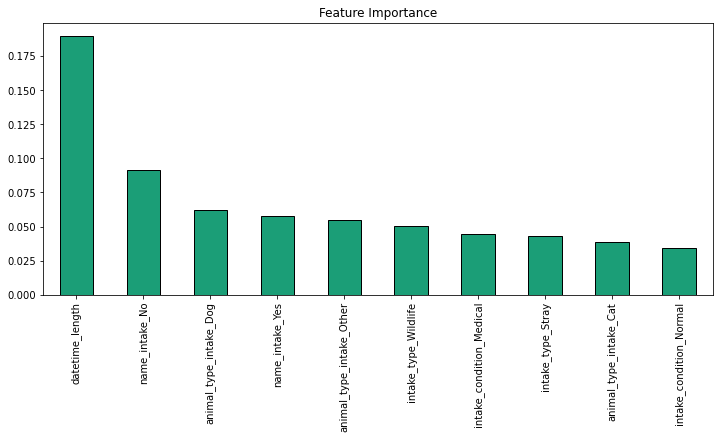

In [63]:
# show feature importance
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='bar', figsize=(12,5), cmap='Dark2', edgecolor='black', title='Feature Importance')
# plt.xticks(rotation=65)

# Boosting Gradient

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
classifier = GradientBoostingClassifier(n_estimators=20,
   learning_rate=0.5, max_features=5, max_depth=3, random_state=0)

classifier.fit(X_resampled, y_resampled)
predictions = classifier.predict(X_test_scaled)

In [66]:
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")
print(classification_report(predictions, y_test, target_names=['Adoption', 'Died', 'Return to Owner','Transfer']))

Accuracy Score : 0.7509144373520763
                 precision    recall  f1-score   support

       Adoption       0.86      0.75      0.80      6306
           Died       0.75      0.70      0.73      1531
Return to Owner       0.81      0.69      0.75      2806
       Transfer       0.59      0.82      0.69      3300

       accuracy                           0.75     13943
      macro avg       0.75      0.74      0.74     13943
   weighted avg       0.77      0.75      0.76     13943



<AxesSubplot:title={'center':'Feature Importance'}>

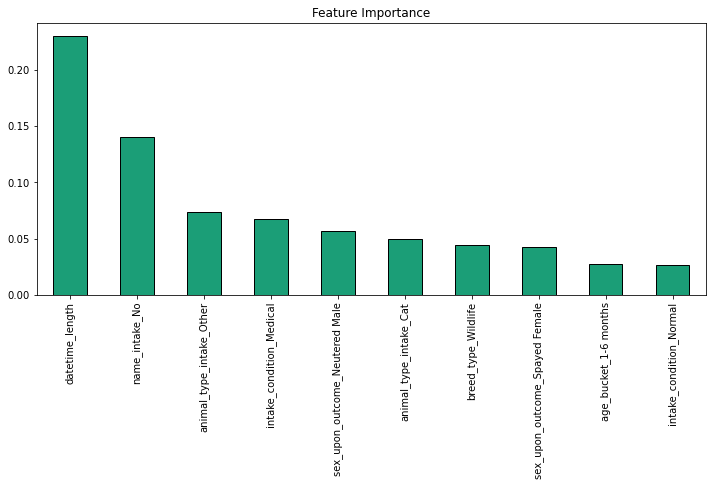

In [69]:
# show feature importance
feat_imp = pd.Series(classifier.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='bar', figsize=(12,5), cmap='Dark2', edgecolor='black', title='Feature Importance')
# plt.xticks(rotation=65)